In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path as path
%matplotlib inline
from tensorflow.keras.preprocessing import image

# Read The Data 

In [2]:
covid_path = path(r"D:\BFCAI\Samsung\Project\train (1)\COVID19")

In [3]:
covid_images = os.listdir(r"D:\BFCAI\Samsung\Project\train (1)\COVID19")

In [4]:
len(covid_images)

460

In [5]:
covid_filepaths = [str(covid_path) + '/' + img_path for img_path in covid_images]

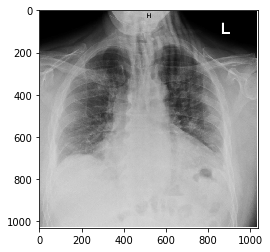

In [11]:
# all images file paths
img = plt.imread(covid_filepaths[2])
plt.imshow(img)
plt.show()

In [6]:
normal_path = path(r"D:\BFCAI\Samsung\Project\train (1)\NORMAL")

In [7]:
normal_images = os.listdir(r"D:\BFCAI\Samsung\Project\train (1)\NORMAL")

In [8]:
len(normal_images)

1341

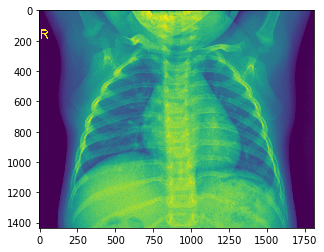

In [15]:
img = plt.imread(str(normal_path)+'/'+normal_images[2])
plt.imshow(img)
plt.show()

In [9]:
normal_filespaths = [str(normal_path) + '/' + img_path for img_path in normal_images]

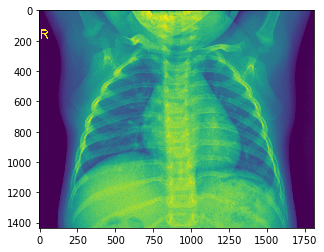

In [17]:
img = plt.imread(normal_filespaths[2])
plt.imshow(img)
plt.show()

# Pre_Processing

In [10]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [11]:
covid_df = proc_img(covid_filepaths)

In [12]:
covid_df.head(1)

,Filepath,Label
0,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19


In [13]:
normal_df = proc_img(normal_filespaths)

In [14]:
normal_df.head(1)

,Filepath,Label
0,D:\BFCAI\Samsung\Project\train (1)\NORMAL/IM-0...,NORMAL


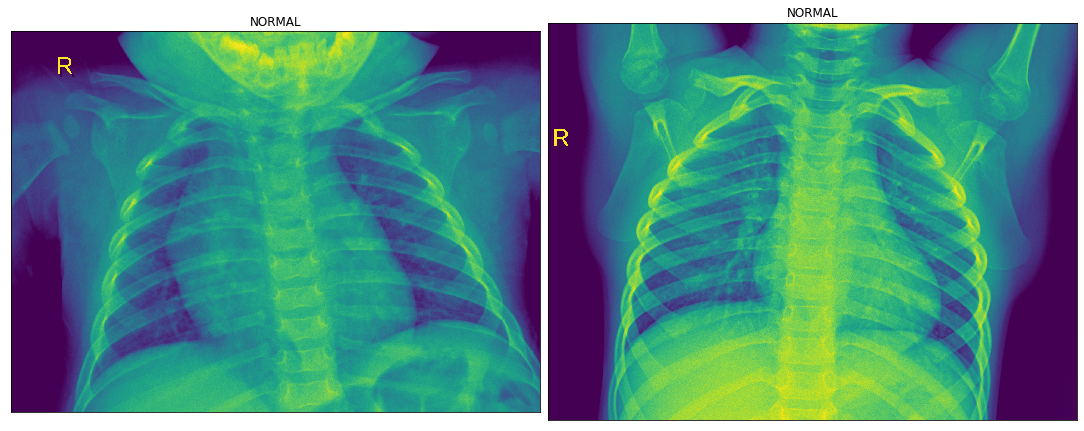

In [23]:
# Display 2 picture of the Normal dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(normal_df.Filepath[i]))
    ax.set_title(normal_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

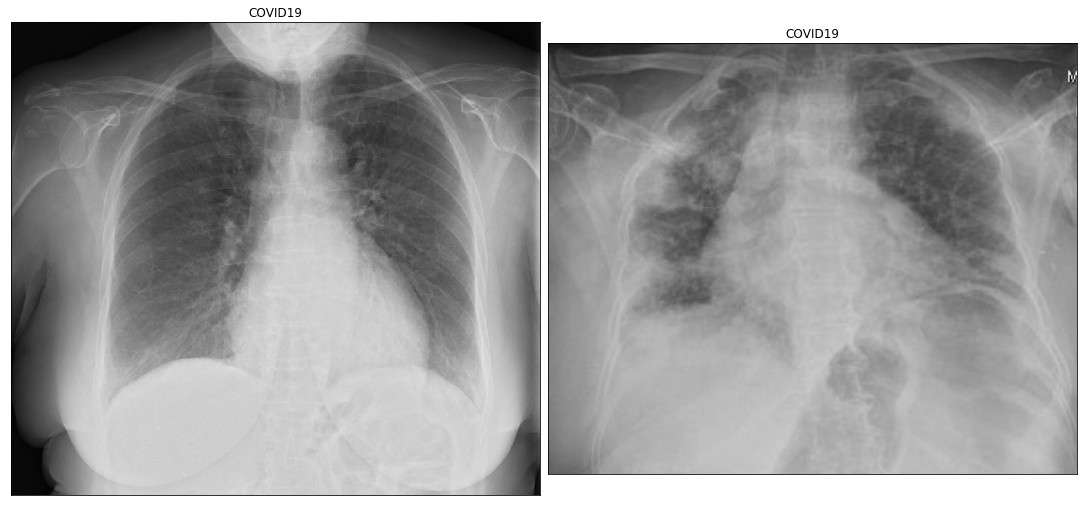

In [16]:
# Display 2 picture of the Covid dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(covid_df.Filepath[i]))
    ax.set_title(covid_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [17]:
# Concat the two data frame(covid and normal)

In [15]:
df = pd.concat([covid_df, normal_df], axis=0)

In [25]:
df.head(2)

,Filepath,Label
0,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
1,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19


In [26]:
df.tail(2)

,Filepath,Label
1339,D:\BFCAI\Samsung\Project\train (1)\NORMAL/IM-0...,NORMAL
1340,D:\BFCAI\Samsung\Project\train (1)\NORMAL/IM-0...,NORMAL


In [27]:
df.Label.value_counts()

NORMAL     1341
COVID19     460
Name: Label, dtype: int64

In [28]:
len(df.Label)

1801

__Train Test Split__

In [23]:
# Take a .2 sample from the data frame
int(len(df) * 0.25)    #  >> num of test images

450

In [29]:
# Test_df
test_df = df.sample(n=450,random_state=42)
test_df.Label.value_counts()

NORMAL     335
COVID19    115
Name: Label, dtype: int64

In [30]:
# Find Rows in df Which Are Not Available in test_df
train_df = df.merge(test_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [31]:
train_df.Label.value_counts()

NORMAL     1006
COVID19     345
Name: Label, dtype: int64

In [32]:
len(train_df.Label)

1351

# Image Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [34]:
# Train generator
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 1351 validated image filenames belonging to 2 classes.


In [35]:
# Test generator
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 450 validated image filenames belonging to 2 classes.


# Model 

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization

In [27]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120,120,1,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation = 'softmax'))  # the output layer

In [28]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

__Model Summary__

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 30)      8670      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 30)        8130      
_________________________________________________________________
flatten (Flatten)            (None, 20280)             0

__Early Stop__

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [31]:
model.fit(train_images, epochs = 12 , validation_data = test_images, verbose=1, callbacks=early_stop)

Epoch 1/12
43/43 [==============================] - 156s 4s/step - loss: 0.6168 - accuracy: 0.7454 - val_loss: 0.5724 - val_accuracy: 0.7444
Epoch 2/12
43/43 [==============================] - 79s 2s/step - loss: 0.5688 - accuracy: 0.7446 - val_loss: 0.5723 - val_accuracy: 0.7444
Epoch 3/12
43/43 [==============================] - 80s 2s/step - loss: 0.5694 - accuracy: 0.7446 - val_loss: 0.5693 - val_accuracy: 0.7444
Epoch 4/12
43/43 [==============================] - 79s 2s/step - loss: 0.5709 - accuracy: 0.7446 - val_loss: 0.5749 - val_accuracy: 0.7444
Epoch 5/12
43/43 [==============================] - 77s 2s/step - loss: 0.5759 - accuracy: 0.7446 - val_loss: 0.5694 - val_accuracy: 0.7444


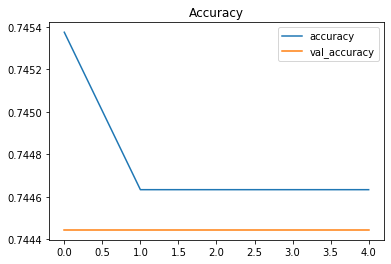

In [32]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()                  

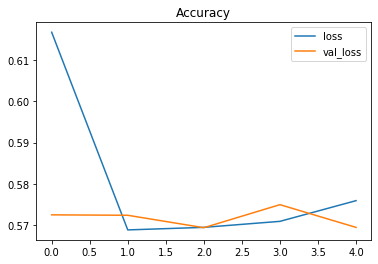

In [33]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Accuracy") 
plt.show()  

__Prediction__

In [34]:
test_df.head()

,Filepath,Label
513,D:\BFCAI\Samsung\Project\train (1)\NORMAL/NORM...,NORMAL
1287,D:\BFCAI\Samsung\Project\train (1)\NORMAL/IM-0...,NORMAL
325,D:\BFCAI\Samsung\Project\train (1)\NORMAL/NORM...,NORMAL
162,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
812,D:\BFCAI\Samsung\Project\train (1)\NORMAL/IM-0...,NORMAL


In [35]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL']


In [38]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score,classification_report

In [32]:
from sklearn.preprocessing import LabelEncoder

In [39]:

le = LabelEncoder()

test_labels = le.fit_transform(test_df.Label)
pred = le.fit_transform(pred)

In [40]:
confusion_matrix = pd.crosstab(test_labels, pred, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,All
Actual,,
0,115,115
1,335,335
All,450,450


# Im_Balanced Data

In [19]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

__under-sample model__

In [20]:
# reduce the majority rows to be equals the miniority one
undersample = RandomUnderSampler(sampling_strategy='majority')

In [21]:
df.head()

,Filepath,Label
0,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
1,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
2,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
3,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
4,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19


In [22]:
X = df.iloc[:, :1].values

In [23]:
X.shape

(1801, 1)

In [24]:
y = df.iloc[:, 1]

In [25]:
X, y = undersample.fit_resample(X, y)

In [26]:
X[1]

array(['D:\\BFCAI\\Samsung\\Project\\train (1)\\COVID19/COVID19(427).jpg'],
      dtype=object)

In [27]:
X.shape

(920, 1)

In [28]:
y[1]

'COVID19'

In [29]:
y.shape

(920,)

In [30]:
# Data Frame must be 1-D
X = X.reshape((920, ))

In [31]:
# to check
from collections import Counter

In [32]:
print(Counter(y))

Counter({'COVID19': 460, 'NORMAL': 460})


In [33]:
balanced_df = pd.DataFrame({'Filepath': X, 'Label': y})

In [34]:
balanced_df.head()

,Filepath,Label
0,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
1,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
2,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
3,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19
4,D:\BFCAI\Samsung\Project\train (1)\COVID19/COV...,COVID19


In [35]:
balanced_df.Label.value_counts()

COVID19    460
NORMAL     460
Name: Label, dtype: int64

In [36]:
balanced_df.duplicated().sum()

0

__Train Test Split__

In [37]:
# Take a .2 sample from the data frame
int(len(balanced_df) * 0.2)    #  >> num of test images

184

In [38]:
# Test_df
test_df = balanced_df.sample(n=184,random_state=42)
test_df.Label.value_counts()

COVID19    98
NORMAL     86
Name: Label, dtype: int64

In [39]:
# Find Rows in balanced_df Which Are Not Available in test_df
train_df = balanced_df.merge(test_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [40]:
train_df.Label.value_counts()

NORMAL     374
COVID19    362
Name: Label, dtype: int64

In [41]:
# Image Generator

In [87]:
# Train generator
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 736 validated image filenames belonging to 2 classes.


In [88]:
# Test generator
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 184 validated image filenames belonging to 2 classes.


# Model

In [89]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120, 120,3,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation = 'softmax'))  # the output layer

In [90]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

__Model Summary__

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 116, 116, 30)      8670      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)        8672      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)            

__Early Stop__

In [92]:
early_stop = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)

In [49]:
model.fit(train_images, epochs = 1 , validation_data = test_images, verbose=1, callbacks=early_stop)

23/23 [==============================] - 58s 2s/step - loss: 0.5831 - accuracy: 0.7785 - val_loss: 0.1433 - val_accuracy: 0.9620


__Visualize the output__

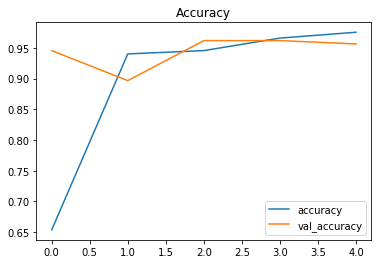

In [178]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()                  

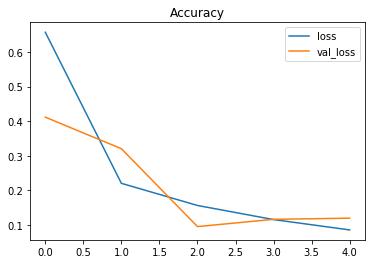

In [179]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Accuracy") 
plt.show()      

# Prediction

In [180]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['COVID19', 'COVID19', 'COVID19', 'COVID19', 'COVID19']


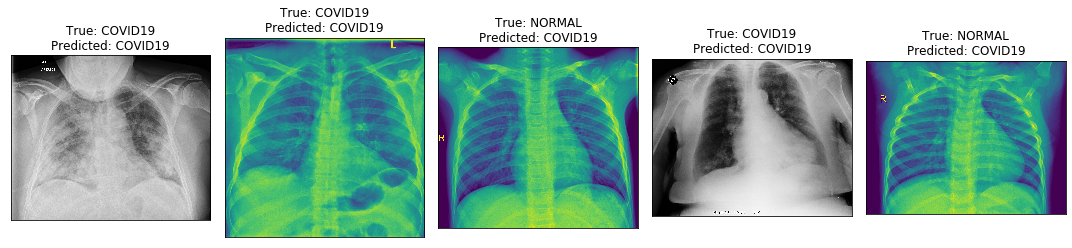

In [182]:
# Display 5 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

In [85]:
# def predict_path(path):
#         path = r'{}'.format(path)
#         img = image.load_img(path, target_size=(120, 120))
#         img_array = image.img_to_array(img)
#         img_batch = np.expand_dims(img_array, axis=0)
#         img_preprocessed = img_batch / 255.0
#         pred = model.predict(img_preprocessed)
#         pred = np.argmax(pred, axis=1)
#         if pred == 0:
#             pred = 'covid'
#         else:
#             pred = 'normal'
#         x = f"the predicted value: {pred}"
#         return x

In [80]:
path = r'D:\\BFCAI\\Samsung\\Project\train (1)\\COVID19\\COVID19(26).jpg'
img = image.load_img(path, target_size=(120, 120))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = img_batch / 255.0
pred = model.predict(img_preprocessed)
pred = np.argmax(pred, axis=1)
if pred == 0:
    pred = 'covid'
else:
    pred = 'normal'
x = f"the predicted value: {pred}"

In [81]:
x

'the predicted value: covid'

__Apply Equalize_Histogram__

In [70]:
import cv2 as cv

In [259]:
def LoadImages(column):
    path_list = []
    for i in range(len(column)):
        try:
            path_list.append(cv.resize(cv.imread(column.loc[i], 0), (150, 150)))
        except:
            continue

    return np.array(path_list)

In [260]:
test_images = []
test_images = LoadImages(test_df.Filepath)

In [261]:
train_images = []
train_images = LoadImages(train_df.Filepath)

In [262]:
train_images.shape

(592, 150, 150)

In [263]:
test_images.shape

(34, 150, 150)

In [264]:
from skimage.exposure import equalize_hist
from skimage import color
from tensorflow.keras.utils import to_categorical

In [265]:
for i in range(train_images.shape[0]):
    train_images[i] = equalize_hist(train_images[i])

In [266]:
for i in range(test_images.shape[0]):
    test_images[i] = equalize_hist(test_images[i])

In [267]:
from sklearn.preprocessing import LabelEncoder 

In [268]:
def label_encoding(column,df):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [269]:
label_encoding('Label', train_df)
label_encoding('Label', test_df)

In [270]:
y_train = []
for i in range(len(train_df)):
    try:
        y_train.append(train_df.Label.loc[i])    
    except:
        continue

In [271]:
y_train = np.array(y_train)
y_train.shape

(592,)

In [272]:
y_train = to_categorical(y_train, 2)

In [273]:
y_test = []
for i in range(len(test_df)):
    try:
        y_test.append(test_df.Label.loc[i])    
    except:
        continue

In [274]:
y_test = np.array(y_test)
y_test.shape

(34,)

In [275]:
y_test = to_categorical(y_test, 2)

In [277]:
X_train = train_images.reshape(train_images.shape[0], 150, 150, 1)
X_test = test_images.reshape(test_images.shape[0], 150, 150, 1)

In [278]:
# X_train = X_train / 255.0
# X_test = X_test / 255.0

In [279]:
X_train.shape

(592, 150, 150, 1)

In [280]:
X_test.shape

(34, 150, 150, 1)

In [281]:
y_train.shape

(592, 2)

In [282]:
y_test.shape

(34, 2)

__Model__

In [283]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(150,150,1)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(AveragePooling2D(4,4))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(2,activation = 'softmax'))  # the output layer

In [284]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [285]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 146, 146, 30)      8670      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 144, 144, 30)      8130      
_________________________________________________________________
average_pooling2d_15 (Averag (None, 36, 36, 30)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 34, 34, 30)        8130      
_________________________________________________________________
flatten_16 (Flatten)         (None, 34680)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)             

In [286]:
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [287]:
model.fit(x = X_train, y = y_train, epochs = 15, verbose=1)

Epoch 1/15
19/19 [==============================] - 30s 2s/step - loss: 0.6584 - accuracy: 0.6030
Epoch 2/15
19/19 [==============================] - 29s 2s/step - loss: 0.5583 - accuracy: 0.8328
Epoch 3/15
19/19 [==============================] - 29s 2s/step - loss: 0.3013 - accuracy: 0.8885
Epoch 4/15
19/19 [==============================] - 30s 2s/step - loss: 0.1927 - accuracy: 0.9409
Epoch 5/15
19/19 [==============================] - 28s 1s/step - loss: 0.1500 - accuracy: 0.9375
Epoch 6/15
19/19 [==============================] - 31s 2s/step - loss: 0.1266 - accuracy: 0.9426
Epoch 7/15
19/19 [==============================] - 31s 2s/step - loss: 0.1009 - accuracy: 0.9595
Epoch 8/15
19/19 [==============================] - 35s 2s/step - loss: 0.0811 - accuracy: 0.9662
Epoch 9/15
19/19 [==============================] - 32s 2s/step - loss: 0.0700 - accuracy: 0.9730
Epoch 10/15
19/19 [==============================] - 36s 2s/step - loss: 0.0543 - accuracy: 0.9747
Epoch 11/15
19/19 [

__Predict__

In [288]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

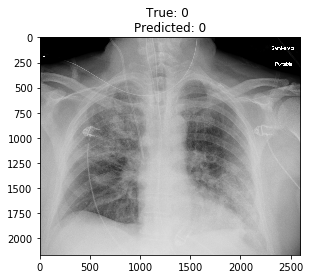

In [289]:
plt.imshow(plt.imread(test_df.Filepath.iloc[1]))
plt.title(f"True: {test_df.Label.iloc[1]} \nPredicted: {pred[1]}")
plt.show()

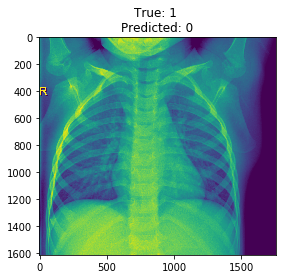

In [290]:
plt.imshow(plt.imread(test_df.Filepath.iloc[7]))
plt.title(f"True: {test_df.Label.iloc[7]} \nPredicted: {pred[7]}")
plt.show()

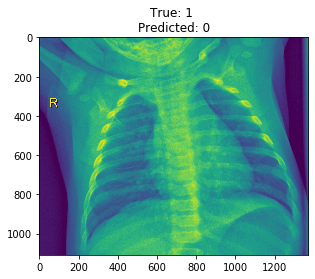

In [291]:
plt.imshow(plt.imread(test_df.Filepath.iloc[8]))
plt.title(f"True: {test_df.Label.iloc[8]} \nPredicted: {pred[8]}")
plt.show()

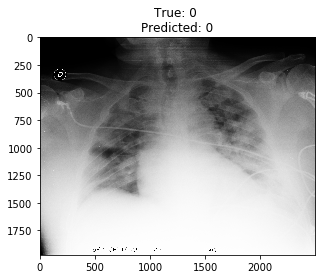

In [292]:
plt.imshow(plt.imread(test_df.Filepath.iloc[15]))
plt.title(f"True: {test_df.Label.iloc[15]} \nPredicted: {pred[15]}")
plt.show()

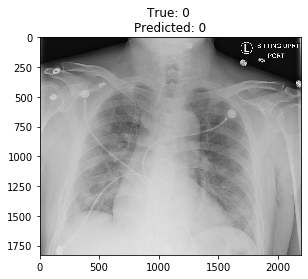

In [293]:
plt.imshow(plt.imread(test_df.Filepath.iloc[3]))
plt.title(f"True: {test_df.Label.iloc[3]} \nPredicted: {pred[3]}")
plt.show()

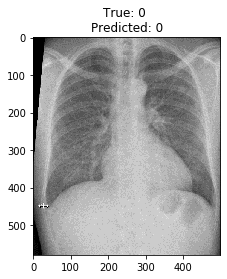

In [294]:
plt.imshow(plt.imread(test_df.Filepath.iloc[23]))
plt.title(f"True: {test_df.Label.iloc[23]} \nPredicted: {pred[23]}")
plt.show()